## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib
#### !pip install pypickle

In [ ]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton#
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit
import pickle


# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constants
E = 192000e6  # Young's modulus in MPa
sigma_y = 110e6  # Yield stress in MPa
h = 7  # Isotropic hardening rate


# Generate strain history
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    alpha, eps_p, delta_gamma = 0, 0, 0
    
    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

        # Store the data
        dataset.append([
            E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, delta_gamma
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [2]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [3]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [4]:
training[:,4]

array([0.0001, 0.0002, 0.0003, ..., 0.0298, 0.0299, 0.03  ])

In [5]:
training[-1]

array([1.92000000e+11, 1.10000000e+08, 7.00000000e+00, 1.92000000e+07,
       3.00000000e-02, 1.10000001e+08, 2.94270833e-02, 1.47135417e-01,
       1.00000000e+00, 1.00000000e-04])

In [6]:
with open('scaler_X_von_mises_10_01_10_0.0001.pkl', 'rb') as file:
    scaler_X = pickle.load(file)

with open('scaler_y_von_mises_10_01_10_0.0001.pkl', 'rb') as file:
    scaler_y = pickle.load(file)

In [7]:
# Separate features and target
X = training[:, :4]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training[:, -1]   # Targets (plastic_strain)

In [8]:
training[:,4]

array([0.0001, 0.0002, 0.0003, ..., 0.0298, 0.0299, 0.03  ])

In [9]:
X_normalized = scaler_X.transform(X)

In [10]:
y = y.reshape(-1, 1)
y_normalized = scaler_y.transform(y)

In [11]:
model= tf.keras.models.load_model('plastic_strain_predictor_model_von_mises_10_01_2025_10_0.0001.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
y_pred_normalized = model.predict(X_normalized)

In [13]:
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized)

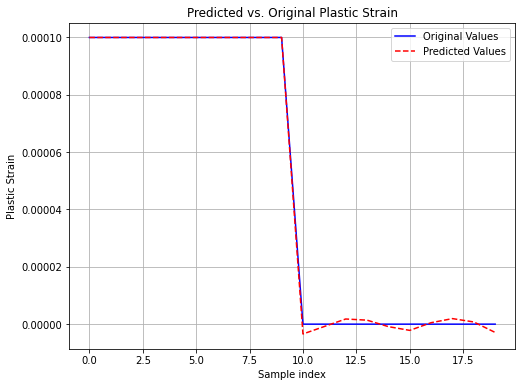

Plot saved as predicted_vs_actual


In [14]:
plot_predicted_vs_actual(y[290:310], y_pred_denormalized[290:310], filename='predicted_vs_actual.png')

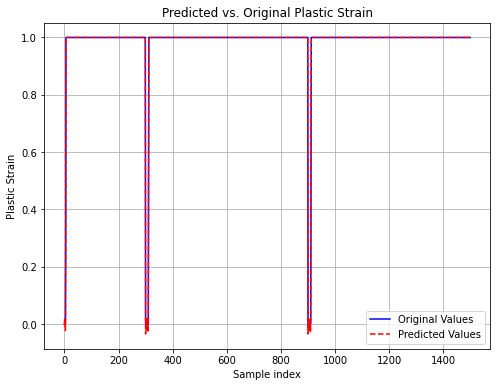

Plot saved as predicted_vs_actual


In [15]:
plot_predicted_vs_actual(y_normalized, y_pred_normalized, filename='predicted_vs_actual.png')

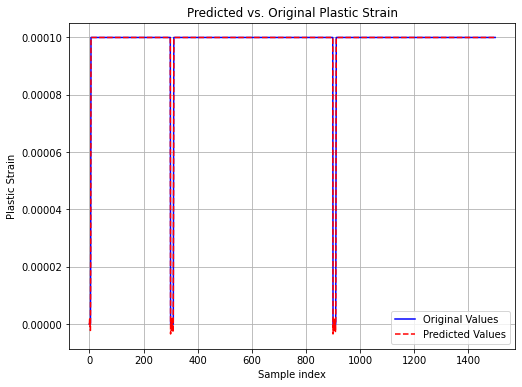

Plot saved as predicted_vs_actual


In [16]:
plot_predicted_vs_actual(y, y_pred_denormalized, filename='predicted_vs_actual.png')

In [17]:
signs = np.sign(training[:,-2])

In [18]:
y_pred_denormalized.shape

(1500, 1)

In [19]:
y_pred_denormalized = np.squeeze(y_pred_denormalized)

In [20]:
y_pred_denormalized.shape

(1500,)

In [21]:
y_pred_denormalized_signed = np.abs(y_pred_denormalized) * signs

In [22]:
y_pred_denormalized_signed=y_pred_denormalized_signed.flatten()[:1500]

In [23]:
cumulative_sum_list1 = np.cumsum(y_pred_denormalized_signed)

In [24]:
stress_nn= 193000e6*(training[:,4]-cumulative_sum_list1)

In [25]:
signs = np.sign(training[:,-2])

In [26]:
y_denormalized_signed = np.abs(np.squeeze(y)) * signs

In [27]:
cumulative_sum_list2 = np.cumsum(y_denormalized_signed)

In [28]:
stress_rm= 193000e6*(training[:,4]-cumulative_sum_list2)

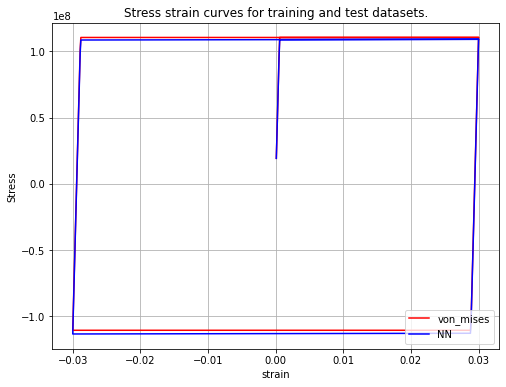

In [29]:
#no. of neurons = 10,with e6 , 0.0001
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

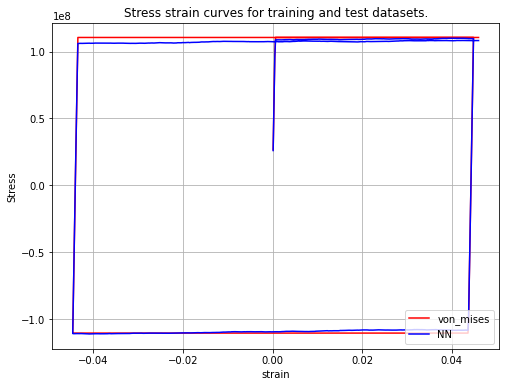

In [203]:
#no. of neurons = 10,with e6
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

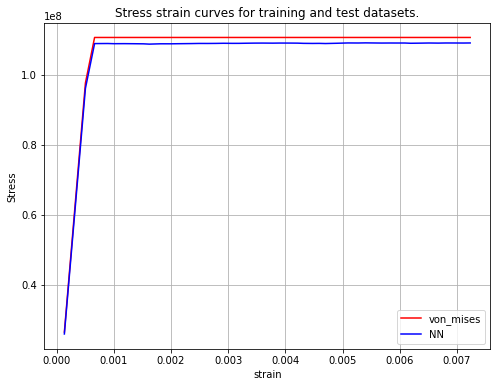

In [202]:
#no. of neurons = 10,with e6
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4][:50], stress_rm[:50], label='von_mises', color='red')
plt.plot(training[:,4][:50], stress_nn[:50], label='NN', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

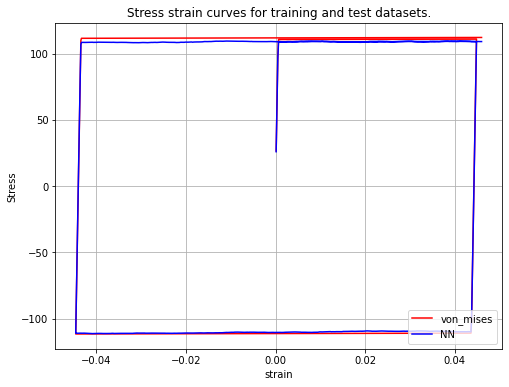

In [168]:
#no. of neurons = 10,without e6
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

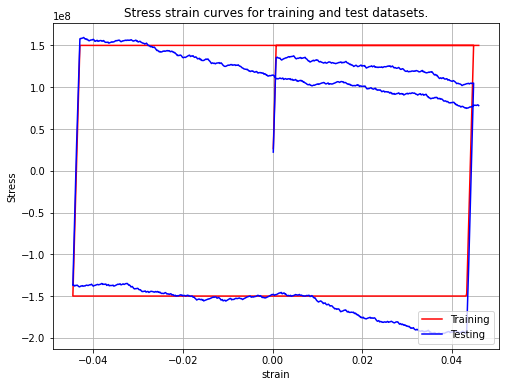

In [29]:
#no. of neurons = 10,500
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

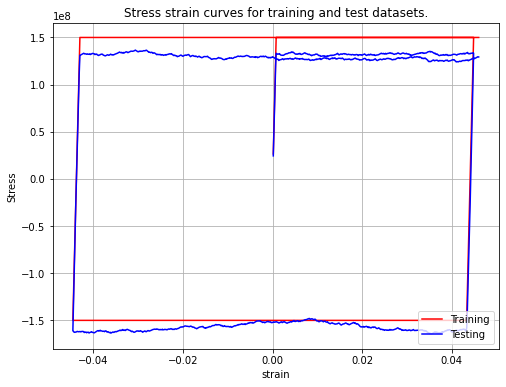

In [203]:
#no. of neurons = 10,1000
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

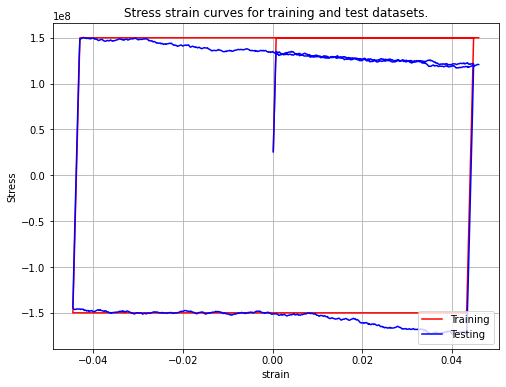

In [174]:
#no. of neurons = 10
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

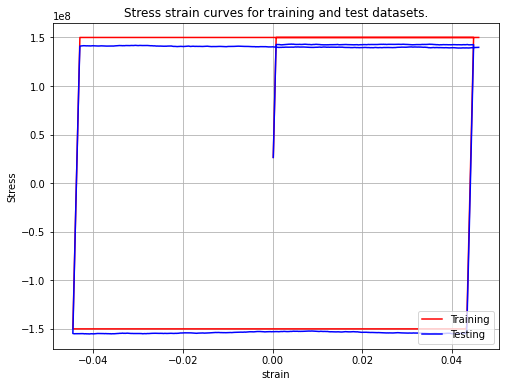

In [145]:
#no. of neurons = 15
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

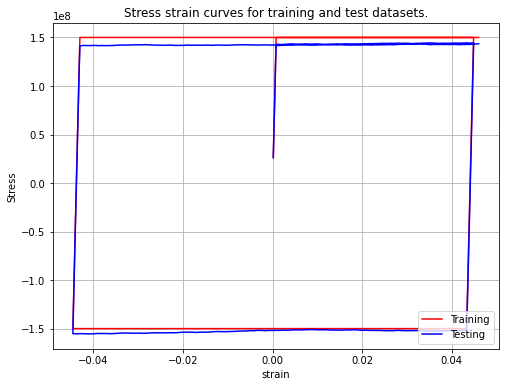

In [116]:
#no. of neurons = 05
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

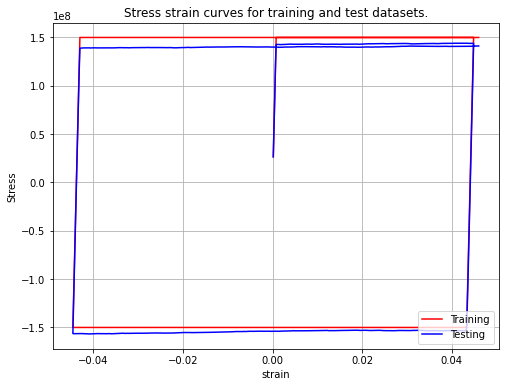

In [87]:
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

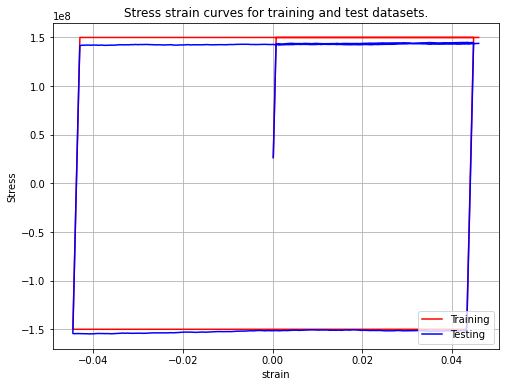

In [58]:
plt.figure(figsize=(8, 6))
#plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.plot(training[:,4], stress_rm, label='Training', color='red')
plt.plot(training[:,4], stress_nn, label='Testing', color='blue')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()